# Классификация MNIST сверточной сетью

https://www.kaggle.com/c/digit-recognizer

In [ ]:
!wget https://www.dropbox.com/s/9wrovo5cugw8xdu/digit-recognizer.zip
!unzip digit-recognizer.zip 

--2021-03-25 17:44:08--  https://www.dropbox.com/s/9wrovo5cugw8xdu/digit-recognizer.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/9wrovo5cugw8xdu/digit-recognizer.zip [following]
--2021-03-25 17:44:08--  https://www.dropbox.com/s/raw/9wrovo5cugw8xdu/digit-recognizer.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccdc5803bbb3313236c14041e77.dl.dropboxusercontent.com/cd/0/inline/BLWfovC7uQuar_Vif5MaE-pJcINqZcA5-bPgQdC6kwQYUMh3XtwmAES0IoIXluk5vw8Su-cw4t41DXTivgL9d4JmMlGC-Gn6C5dTpGyfOtO3xvPi1vFeb6MZMUvt2zt1kNMgZM61BJ4YmYGB7nYfvDaa/file# [following]
--2021-03-25 17:44:09--  https://uccdc5803bbb3313236c14041e77.dl.dropboxusercontent.com/cd/0/inline/BLWfovC7uQuar_Vif5MaE-pJcINqZcA5-bPgQdC6kwQYUMh3XtwmAES0IoIXluk

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

print(tf.__version__)
print(tf.executing_eagerly())

2.4.1
True


In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
# добавляем размерность канала
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28, 1))
test_img = np.resize(test, (test.shape[0], 28, 28, 1))

## Визуализируем исходные данные

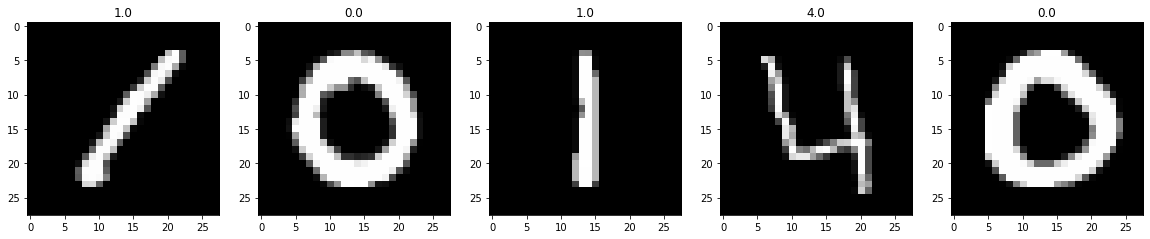

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5, :], 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[:,:,0], cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Разбиваем выборку на обучение и валидацию

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img, test_size=0.2, random_state=42)

## Собираем сверточную сеть для обучения

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=6,
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu',
                           input_shape=x_train.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Conv2D(filters=16, 
                           kernel_size=(5, 5),
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3

## One-hot кодировка разметки

In [ ]:
y_train_labels = tf.keras.utils.to_categorical(y_train)

In [ ]:
print(y_train.shape)
print(y_train_labels.shape)

(33600,)
(33600, 10)


## Запускаем обучение

In [ ]:
model.fit(x_train, 
          y_train_labels,
          batch_size=32, 
          epochs=5,
          validation_split=0.2)

Epoch 1/5
840/840 [==============================] - 33s 3ms/step - loss: 2.6211 - accuracy: 0.6638 - val_loss: 0.2079 - val_accuracy: 0.9408
Epoch 2/5
840/840 [==============================] - 2s 3ms/step - loss: 0.1579 - accuracy: 0.9529 - val_loss: 0.1362 - val_accuracy: 0.9586
Epoch 3/5
840/840 [==============================] - 2s 3ms/step - loss: 0.0928 - accuracy: 0.9711 - val_loss: 0.1273 - val_accuracy: 0.9674
Epoch 4/5
840/840 [==============================] - 2s 3ms/step - loss: 0.0706 - accuracy: 0.9764 - val_loss: 0.1209 - val_accuracy: 0.9638
Epoch 5/5
840/840 [==============================] - 2s 3ms/step - loss: 0.0576 - accuracy: 0.9808 - val_loss: 0.0923 - val_accuracy: 0.9744


## Предсказываем класс объекта

In [ ]:
y_pred = model.predict(x_val)
y_pred_labels = np.argmax(y_pred, axis=1)

## Оцениваем качество решение на валидационной выборке

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred_labels))

Accuracy: 0.9719047619047619


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred_labels))

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98       816
         1.0       0.98      0.98      0.98       909
         2.0       0.97      0.98      0.98       846
         3.0       0.98      0.97      0.98       937
         4.0       0.95      0.98      0.97       839
         5.0       0.98      0.97      0.97       702
         6.0       0.97      0.97      0.97       785
         7.0       0.99      0.96      0.97       893
         8.0       0.97      0.96      0.97       835
         9.0       0.94      0.97      0.95       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



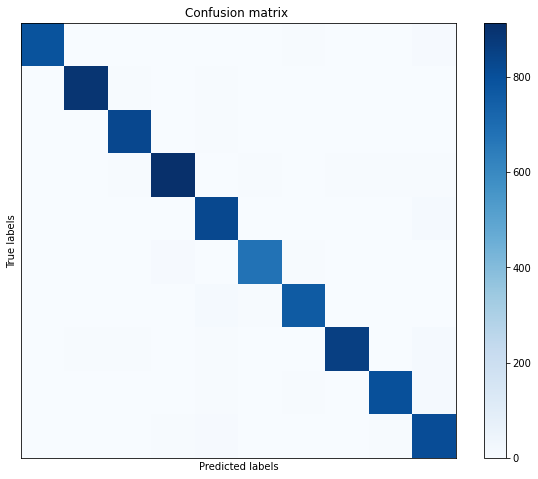

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred_labels)

plt.figure(figsize=(10, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

## Визуализируем предсказания для тестовой выборки

In [ ]:
y_pred_test = model.predict(test_img)
y_pred_test_labels = np.argmax(y_pred_test, axis=1)

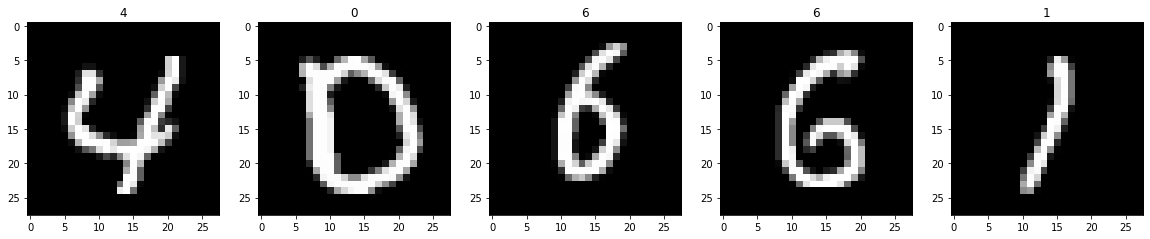

In [ ]:
fig = plt.figure(figsize=(20, 10))
indices = np.random.choice(range(len(test_img)), 5)
img_prediction = zip(test_img[indices], y_pred_test_labels[indices])
for i, (img, pred) in enumerate(img_prediction, 1):
    subplot = fig.add_subplot(1, 5, i)
    plt.imshow(img[...,0], cmap='gray');
    subplot.set_title('%d' % pred);

## Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test_labels, 1):
        dst.write('%s,%d\n' % (i, p))

In [ ]:
# Your submission scored 0.96814